<img src="PEST++V3_cover.jpeg" style="float: left">

<img src="flopylogo.png" style="float: right">

<img src="AW&H2015.png" style="float: center">

# Comparing Local Sensitivity to Global Sensitivity Analysis (GSA)

Sensitivity methods we've looked at so far only evaluate the "local" sensitivity at a single set of parameter values.  For example, the Jacobian matrix represents perturbations to a single set of parameter values.  This local view can be a problem in cases when our inverse problem is nonlinear, which means the parameter sensitivities can change depending on what the parameter value is. In contrast, Global Sensitivity Analyses are statistical approaches that characterize how model parameters affect model outputs over a __wide range__ of acceptable parameter values. Because we often test a number of parameter sets during parameter estimation, GSA methods provide a more robust view of parameter sensitivity compared to traditional, derivative-based local sensitivity analysis. Some GSA methods provide general information about the variability of the sensitivities and have relatively low computational requirements, whereas others provide detailed information on nonlinear behavior and interactions between parameters at the expense of larger computational requirements. For a complete introduction to GSA theory and methods, see Saltelli and others (2004, 2008).

### Local Sensitivity Equation
Recall the local sensitivity equation (eq. 9.7 Anderson et al. 2015):

<img src="Sensitivity_eq.png" style="float: center">

In GSA the change in parameter is not just small perturbations (usually 1%) around the parameter value but rather spans the reasonable parameter range.  What is a reasonable range?  For convenience GSA++ uses the parameter bounds that you specify in your PEST Control File.

Anothe way to look at this finite-difference approximation is:

For each parameter-observation combination, we can see how much the observation value changes due to a small change in the parameter. If $y$ are the observations and $x$ are the parameters, the equation for the $i^th$ observation with respect to the $j^th$ parameter is:  
## $\frac{\partial y_i}{\partial x_j}$
This can be approximated by finite differences as :  
## $\frac{\partial y_i}{\partial x_j}~\frac{y\left(x+\Delta x \right)-y\left(x\right)}{\Delta x}$

### But we only do this around one set of parameter values.  What if we looked at more than one set of parameters?

### That's what GSA does, but lots of parameters evaluated = lots of computer time.  Luckily we can use the PEST++ engine to run GSA in parallel

GSA++ is a stand-alone program distributed with the PEST++ Version 3 suite of tools that perform GSA. It leverages the PEST++ parallel run manger YAMR, and is fully compatible with PEST/PEST++ file formats, including template and instruction files. For us this means we can access the insight of GSA using parallel computing without changing our files. More GSA++ running details are provided in appendix 6 of the PEST++ V3 Techniques and Methods Report. Appendixes 7 and 8 demonstrate the use of GSA++ for a Method of Morris and Sobol example problem.  In this notebook we'll run GSA on the Freyburg model.

### Brief take on GSA Theory from the PEST++ T&M Report (Welter et al. 2015 pages 5-7):

The program GSA++ currently supports two GSA methods: (1) the __Method of Morris__ (Morris, 1991), and (2) the __Method of Sobol__ (Sobol, 2001). In the class we'll focus on the Method of Morris because it is computationally more efficient. But this efficiency comes with a tradeoff: the Method of Morris only provides estimates of the mean and variance of the sensitivity distribution for each parameter. Because of the lack of complete description of the parameter nonlinearity and interactions between parameters, the Method of Morris can be used as a screening-level tool to identify the most important parameters for the observations tested. This screening can be followed by application of a more comprehensive tool, such as the Method of Sobol, which further characterizes the effects of parameter nonlinearity and inter-parameter interactions. 

The Method of Morris is referred to as a “one-at-a-time” method because each parameter is perturbed sequentially to compute sensitivities, which is ideally suited for parallel computing. The method samples the sensitivity of a given parameter at several locations over the range of reasonable parameter space (__defined by the parameter bounds in the PEST Control file__) and then provides two measures of parameter sensitivity: the mean (__μ__) and the standard deviation (__σ__) of the resulting sensitivity distribution. The mean, __μ__, captures the overall effect of a parameter on the model output of interest; the standard deviation, __σ__, measures a parameter’s sensitivity across the range of acceptable parameter values, this being an indicator of how nonlinear a given parameter is and (or) how the parameter interacts with other parameters. It is important to note that the Method of Morris __cannot distinguish__ between parameter nonlinearity and parameter interactions because only the standard deviation of parameter sensitivity is available. 

#### For the class we'll focus on the easiest way to get in the GSA game using pyemu, but this is also likely what you would start with in 95% of the models you evaluate.  For convenience, widely applicable default values are supplied for you by pyemu but can easily be changed by editing the *.gsa* file pyemu creates  (see Appendix 6 in the PEST++ V3 report for descriptions of the *.gsa* variables). 

### The objectives of this notebook are:

1) to calculate local sensitivities for the Freyberg zone model and evaluate them

2) look at the Method of Morris GSA results for the same parameters

In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;

import shutil

sys.path.insert(0,os.path.join("..", "..", "dependencies"))
import pyemu
import flopy
assert "dependencies" in flopy.__file__
assert "dependencies" in pyemu.__file__
sys.path.insert(0,"..")
import herebedragons as hbd

plt.rcParams['font.size'] = 10
pyemu.plot_utils.font =10

In [2]:
# folder containing original model files
org_d = os.path.join('..', '..', 'models', 'monthly_model_files_1lyr_newstress')
# a dir to hold a copy of the org model files
working_dir = os.path.join('freyberg_mf6')
if os.path.exists(working_dir):
    shutil.rmtree(working_dir)
shutil.copytree(org_d,working_dir)
# get executables
hbd.prep_bins(working_dir)
# get dependency folders
hbd.prep_deps(working_dir)
# run our convenience functions to prepare the PEST and model folder
hbd.prep_pest(working_dir)
# convenience function that builds a new control file with pilot point parameters for hk
hbd.add_ppoints(working_dir)

ins file for heads.csv prepared.
ins file for sfr.csv prepared.
noptmax:0, npar_adj:1, nnz_obs:24
written pest control file: freyberg_mf6\freyberg.pst
   could not remove start_datetime
1 pars added from template file .\freyberg6.sfr_perioddata_1.txt.tpl
6 pars added from template file .\freyberg6.wel_stress_period_data_10.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_11.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_12.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_2.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_3.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_4.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_5.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_6.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_7.txt.tpl
0 pars added from template file .\freyberg6.wel_s

#### Let's double check what parameters we have in this version of the model using pyemu (you can just look in the PEST control file too....)

In [3]:
pst_name = "freyberg_pp.pst"

pst = pyemu.Pst(os.path.join(working_dir,pst_name))

#update paramter transform
par = pst.parameter_data
#par.loc['rch0', 'partrans'] = 'log'
par.loc['rch1', 'partrans'] = 'log'
#par.loc[par.pargp=='rchpp', 'partrans'] = 'fixed'
#par.loc[par.pargp=='strinf', 'partrans'] = 'fixed'
#par.loc[par.pargp=='wel', 'partrans'] = 'fixed'
# write
pst.write(os.path.join(working_dir, pst_name))

pst.parameter_data

noptmax:0, npar_adj:66, nnz_obs:37


,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra,i,j,zone
parnme,,,,,,,,,,,,,,
ne1,ne1,fixed,factor,0.01,0.005,0.02,porosity,1.0,0.0,1,NaN,NaN,NaN,NaN
rch0,rch0,fixed,factor,1.00,0.500,2.00,rch0,1.0,0.0,1,NaN,NaN,NaN,NaN
rch1,rch1,log,factor,1.00,0.500,2.00,rch1,1.0,0.0,1,NaN,NaN,NaN,NaN
strinf,strinf,log,factor,500.00,50.000,5000.00,strinf,1.0,0.0,1,NaN,NaN,NaN,NaN
wel5,wel5,log,factor,300.00,10.000,900.00,wel,-1.0,0.0,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rch_i:32_j:17_zone:1.0,rch_i:32_j:17_zone:1.0,log,factor,1.00,0.500,2.00,rchpp,1.0,0.0,1,NaN,32,17,1.0
rch_i:27_j:17_zone:1.0,rch_i:27_j:17_zone:1.0,log,factor,1.00,0.500,2.00,rchpp,1.0,0.0,1,NaN,27,17,1.0
rch_i:17_j:2_zone:1.0,rch_i:17_j:2_zone:1.0,log,factor,1.00,0.500,2.00,rchpp,1.0,0.0,1,NaN,17,2,1.0


# It's the zone version of the Freyberg model.  

### We'll be comparing local vs global sensitivity so we have to calculate both.  

# 1) Local Sensitivity

First Let's calculate a single Jacobian by changing the NOPTMAX = -2.  This will need npar+1 runs, or 10+1 = 11 runs. The Jacobian matrix we get is the local-scale sensitivity information

In [4]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.control_data.noptmax = -2
pst.write(os.path.join(working_dir,pst_name))

noptmax:-2, npar_adj:66, nnz_obs:37


In [5]:
num_workers = 10
m_d = 'master_gsa'
pyemu.os_utils.start_workers(working_dir, # the folder which contains the "template" PEST dataset
                            'pestpp-glm', #the PEST software version we want to run
                            pst_name, # the control file to use with PEST
                            num_workers=num_workers, #how many agents to deploy
                            worker_root='.', #where to deploy the agent directories; relative to where python is running
                            master_dir=m_d, #the manager directory
                            )

#### Let's echo out the working directory in case you want to look at the files that were just created...

In [6]:
os.getcwd()

'd:\\Workspace\\hugm0001\\github\\GMDSI_notebooks_fork\\tutorials\\part1_xx3_global_sensitivity'

### Okay, let's examing the *local sensitivities* by looking at the local gradients of parameters with respect to observations (the Jacobian matrix from the PEST++ NOPTMAX = -2 run)

We'll use pyemu to do this:

In [7]:
jco = pyemu.Jco.from_binary(os.path.join(m_d,pst_name.replace(".pst",".jcb")))
jco_df = jco.to_dataframe()

jco_df = jco_df.loc[pst.nnz_obs_names,:]
jco_df.head()

,rch1,strinf,wel5,wel2,wel4,wel3,wel1,wel0,hk_i:7_j:17_zone:1.0,hk_i:27_j:7_zone:1.0,...,rch_i:27_j:12_zone:1.0,rch_i:12_j:2_zone:1.0,rch_i:37_j:7_zone:1.0,rch_i:22_j:7_zone:1.0,rch_i:27_j:2_zone:1.0,rch_i:32_j:17_zone:1.0,rch_i:27_j:17_zone:1.0,rch_i:17_j:2_zone:1.0,rch_i:2_j:2_zone:1.0,rch_i:37_j:17_zone:1.0
gage-1:3652.5,0.0,1120.270879,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.044133,20.087258,...,227.072405,173.196462,98.946512,201.792497,171.733547,220.487806,239.371835,169.624779,197.846215,125.884552
gage-1:3683.5,0.0,1144.361274,-120.824878,-243.792499,-15.308866,-63.328247,-167.669361,-241.879117,9.251224,21.790456,...,245.759428,187.093069,104.070669,214.076948,178.352181,240.753192,262.919417,181.377647,219.383469,138.164313
gage-1:3712.5,0.0,1149.171568,-208.255099,-361.950602,-42.397402,-134.286346,-283.110736,-372.891340,14.771098,21.938663,...,278.008231,191.520864,110.314571,225.208509,181.892606,282.870630,306.097886,185.631787,225.147437,165.451984
gage-1:3743.5,0.0,1152.525457,-269.555554,-434.848044,-77.830036,-201.182368,-365.438861,-455.575631,22.803051,23.318443,...,317.089581,197.967518,120.371654,243.734795,188.181135,331.992336,357.641690,191.958304,233.585957,195.140729
gage-1:3773.5,0.0,1153.402937,-310.231299,-483.416828,-113.758463,-255.387502,-424.120710,-509.916327,28.336116,25.258422,...,345.761227,205.032819,130.602200,263.589079,196.353881,364.964156,393.608459,198.936449,243.462682,213.084043


we can see that some parameters (rch_0) has a large effect on the observations used for calibration.  The future recharge (rch_1) has no effect on the calibration observations, but that makes sense as none of the calibration observations are in that future stress period!

# How about Composite Scaled Sensitivities
As can be seen above, parameter sensitivity for any given parameter is split among all the observations in the Jacobian matrix, but the parameter sensitivity that is most important for parameter estimation is the *total* parameter sensitivity, which reflects contributions from all the observations.  

How to sum the individual sensitivities in the Jacobian matrix in the most meaningful way?  In the traditional, overdetermined regression world, CSS was a popular metric. CSS is Composite Scaled Sensitivitity. It sums the observation *weighted* sensitivity to report a single number for each parameter.

In Hill and Tiedeman (2007) this is calculated as: 
## ${css_{j}=\sqrt{\left(\sum_{i-1}^{ND}\left(\frac{\partial y'_{i}}{\partial b_{j}}\right)\left|b_{j}\right|\sqrt{w_{ii}}\right)/ND}}$

In PEST and PEST++, John Doherty calculates it slightly differently in that scaling by the parameter values happens automatically when the parameter is subjected to a log-transform (and we can see above that all our parameters are logged). This is due to a correction that must be made in calculating the Jacobian matrix and follows from the chain rule of derivatives.  Seems somewhat academic, but let's compare the two:


In [8]:
sc = pyemu.Schur(jco=os.path.join(m_d,pst_name.replace(".pst",".jcb")))
css_df = sc.get_par_css_dataframe()
css_df

,pest_css,hill_css
rch1,0.000000,0.000000
strinf,0.556815,0.040617
wel5,0.156967,NaN
wel2,0.235268,NaN
wel4,0.130818,NaN
...,...,...
rch_i:32_j:17_zone:1.0,0.127119,0.000000
rch_i:27_j:17_zone:1.0,0.139244,0.000000
rch_i:17_j:2_zone:1.0,0.111634,0.000000
rch_i:2_j:2_zone:1.0,0.153943,0.000000


## Hmm, the relative ranks agree between the two...OOPS! Check out rch_0!  We can see from the Jacobian print out above that rch_0 is the *most* sensitive, but the CSS statistics don't  both say that!  Why might this be?

hint: what is the initial value of rch_0?  What is the log of that initial value?  

##  Okay, let's look at just the PEST CSS and rank/plot it:

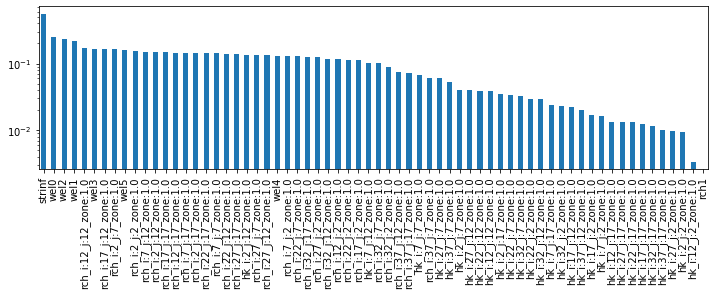

In [9]:
plt.figure(figsize=(12,3))
ax = css_df['pest_css'].sort_values(ascending=False).plot(kind='bar')
ax.set_yscale('log')

# So how do these parameter sensitivities affect the forecasts?  

###  Recall that the sensitivity is calculated by differencing the two model outputs, so any model output can have a sensitivity calculated even if we don't have a measured value.  So, because we included the forecasts as observations we have sensitivities for them in our Jacobian matrix.  Let's use pyemu to pull just these forecasts....

In [10]:
jco_fore_df = sc.forecasts.to_dataframe()
jco_fore_df.head()

,headwater:4383.5,tailwater:4383.5,trgw-0-9-1:4383.5,part_time
rch1,-2091.812821,-1539.075668,5.172705,-401.726184
strinf,2.990537,8.439942,0.030474,-18.054907
wel5,10.105829,21.877808,-0.043456,-47.648042
wel2,14.339045,14.365979,-0.043940,-20.061676
wel4,34.932376,65.335448,-0.187389,-163.591264


## Note that porosity is 0.000 except for the travel time forecast, which makes sense.  

### Perhaps less obvious is rch_0 - why does it have sensitivity when all the forecasts are in the period that has rch_1 recharge? 

### Now let's consider posterior covariance 

In [32]:
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df().head()

,rch1,strinf,wel5,wel2,wel4,wel3,wel1,wel0,hk_i:7_j:17_zone:1.0,hk_i:27_j:7_zone:1.0,...,rch_i:27_j:12_zone:1.0,rch_i:12_j:2_zone:1.0,rch_i:37_j:7_zone:1.0,rch_i:22_j:7_zone:1.0,rch_i:27_j:2_zone:1.0,rch_i:32_j:17_zone:1.0,rch_i:27_j:17_zone:1.0,rch_i:17_j:2_zone:1.0,rch_i:2_j:2_zone:1.0,rch_i:37_j:17_zone:1.0
rch1,3.310813e-52,5.616738e-53,-5.715799e-54,-6.630929e-54,-1.285323e-53,-1.127573e-53,-9.227413e-54,-6.368659e-54,4.129115e-55,-2.603127e-54,...,3.848684e-54,1.210124e-53,3.083079e-54,6.703012e-54,9.151096e-54,1.425093e-54,1.824036e-54,1.145960e-53,1.276891e-53,6.944860e-55
strinf,5.616738e-53,4.244482e+02,-1.107656e+02,-1.681681e+02,-6.071951e+01,-1.053190e+02,-1.547466e+02,-1.758415e+02,5.939708e-01,8.262696e+00,...,9.466655e+01,7.606745e+01,4.254819e+01,8.792567e+01,7.401507e+01,8.932119e+01,9.865193e+01,7.379336e+01,9.099092e+01,5.017724e+01
wel5,-5.715799e-54,-1.107656e+02,3.373046e+01,5.037216e+01,2.104357e+01,3.380922e+01,4.679896e+01,5.249801e+01,2.209543e-01,-1.159244e+00,...,-2.491497e+01,-2.082368e+01,-1.163345e+01,-2.420650e+01,-2.110747e+01,-2.270078e+01,-2.523905e+01,-2.049266e+01,-2.458093e+01,-1.262280e+01
wel2,-6.630929e-54,-1.681681e+02,5.037216e+01,7.577527e+01,2.955021e+01,4.926207e+01,7.017748e+01,7.913078e+01,1.911498e-01,-2.641769e+00,...,-3.788193e+01,-3.117218e+01,-1.742603e+01,-3.617201e+01,-3.093589e+01,-3.503154e+01,-3.887668e+01,-3.042499e+01,-3.719452e+01,-1.953212e+01
wel4,-1.285323e-53,-6.071951e+01,2.104357e+01,2.955021e+01,2.342819e+01,2.734695e+01,2.727481e+01,2.963655e+01,7.273875e-01,5.753521e+00,...,-1.558478e+01,-1.490198e+01,-8.411194e+00,-1.829892e+01,-1.966633e+01,-1.145047e+01,-1.298096e+01,-1.630663e+01,-1.510385e+01,-6.211568e+00


For covariance, very small numbers reflect that the parameter doesn't covary with another.  Does it make sense that rch_1 does not covary with other parameters?

### We can visualize the correlation betwen the two parameters using a correlation coefficient

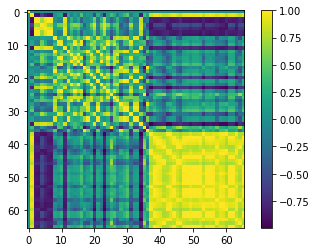

In [12]:
R = covar.to_pearson()
plt.imshow(R.df(), interpolation='nearest', cmap='viridis')
plt.colorbar()

As expected, the parameters are correlated perfectly to themselves (1.0 along the yellow diagonal) buth they also can have appreciable correlation to each other, both positively and negatively 

#### Using zone hk_z03, let's look only at the parameters that have correlation > 0.5

In [34]:
cpar = 'rch_i:12_j:12_zone:1.0'
R.df().loc[cpar][np.abs(R.df().loc[cpar])>.5]

strinf                    0.957545
wel5                     -0.890032
wel2                     -0.909004
wel4                     -0.573685
wel3                     -0.789966
wel1                     -0.891873
wel0                     -0.910985
hk_i:37_j:17_zone:1.0    -0.792038
hk_i:32_j:2_zone:1.0     -0.593785
hk_i:37_j:12_zone:1.0    -0.753620
hk_i:37_j:7_zone:1.0     -0.835852
rch_i:32_j:2_zone:1.0     0.838964
rch_i:37_j:12_zone:1.0    0.982280
rch_i:7_j:12_zone:1.0     0.990987
rch_i:2_j:12_zone:1.0     0.966127
rch_i:7_j:2_zone:1.0      0.852257
rch_i:22_j:2_zone:1.0     0.819109
rch_i:32_j:7_zone:1.0     0.910418
rch_i:7_j:17_zone:1.0     0.993008
rch_i:7_j:7_zone:1.0      0.924855
rch_i:2_j:7_zone:1.0      0.846567
rch_i:2_j:17_zone:1.0     0.995596
rch_i:12_j:17_zone:1.0    0.989992
rch_i:22_j:12_zone:1.0    0.985569
rch_i:17_j:17_zone:1.0    0.987200
rch_i:22_j:17_zone:1.0    0.984711
rch_i:12_j:12_zone:1.0    1.000000
rch_i:27_j:7_zone:1.0     0.852169
rch_i:32_j:12_zone:1

Saying parameters are correlated is really saying that when a parameter changes it has a similar effect on the observations as the other parameter(s). So in this case that means that when hk_z03 increases it has a similar effect on observations as increasing hk_z02.  If we add a new observation type (or less powerfully, a new location) we can break the correlation.  And we've seen this:  adding a flux observation broke the correlation between R and K!

We can use this pyemu picture to interrogate the correlation - here we say plot this but cut out all that correlations under 0.9.  Play with this by putting other numbers between 0.3 and 1.0 and re-run the block below.

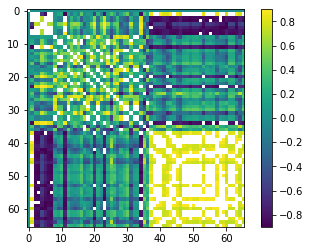

In [14]:
R_plot = R.as_2d.copy()
R_plot[np.abs(R_plot)>0.9] = np.nan
plt.imshow(R_plot, interpolation='nearest', cmap='viridis')
plt.colorbar()

In practice, correlation >0.95 or so becomes a problem for the parameter estimation problem.  

# 2. Global Sensitivity
### Secondly, let's run GSA, a global sensitivity analysis tool.  By default (no extra settings), GSA will run the Method of Morris with 4 discretization points for each parameter (36 runs) plus the 4 new starting points from the intial conditions (4 runs). That is, 44 runs instead of the 11 needed for the local sensitivity method, so we'll use sweep.

In [15]:
pyemu.os_utils.start_workers(working_dir, # the folder which contains the "template" PEST dataset
                            'pestpp-sen', #the PEST software version we want to run
                            pst_name, # the control file to use with PEST
                            num_workers=num_workers, #how many agents to deploy
                            worker_root='.', #where to deploy the agent directories; relative to where python is running
                            master_dir=m_d, #the manager directory
                            )

#### Again, let's echo out the working directory in case you want to look at the files that were just created...

In [16]:
os.getcwd()

'd:\\Workspace\\hugm0001\\github\\GMDSI_notebooks_fork\\tutorials\\part1_xx3_global_sensitivity'

## GSA results

Let's look at a table and plot of the GSA results.  In this case we are looking at the mean sensitivity, and the standard deviation of the sensitivity as you change the starting value in the parameter space.  

> If the __mean sensitivity is high__ it shows that parameter has higher sensitivity across the parameter space.  

>If the __standard deviation is low__, then the linear assumptions of FOSM hold (that is, the sensitivity is the similar regardless of starting value).  

In [17]:
df = pd.read_csv(os.path.join(m_d,pst_name.replace(".pst",".msn")),skipinitialspace=True)
df.loc[:,"parnme"] = df.pop("parameter_name").apply(lambda x : x.lower().replace("log(",'').replace(')',''))
df.index = df.parnme
df.head()

,n_samples,sen_mean,sen_mean_abs,sen_std_dev,parnme
parnme,,,,,
rch1,4,0.000,0.000,0.000,rch1
strinf,4,405.552,4934.630,7635.800,strinf
wel5,4,-553.984,553.984,884.045,wel5
wel2,4,-276.242,692.051,1137.280,wel2
wel4,4,127.936,127.936,139.486,wel4


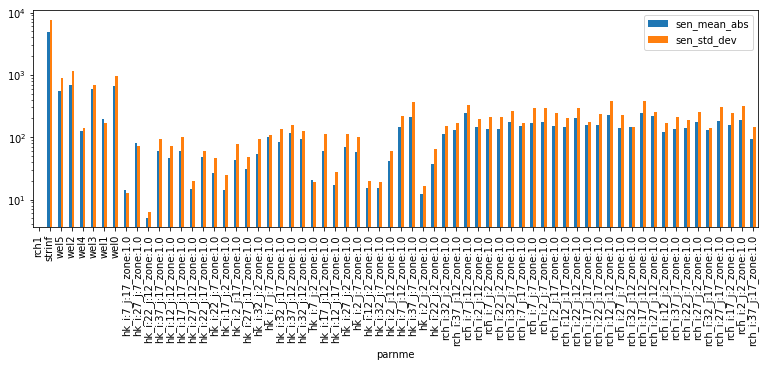

In [41]:
df.loc[:,["sen_mean_abs","sen_std_dev"]].plot(kind="bar", figsize=(13,4))
plt.yscale('log');

### Interesting!  ``hk_z03`` is more sensitive across parameter space compared to the other HK parameters but hk_z02 is similar (hmm, weren't these two correlated above?)...and it and ``rch_0`` looks to be suffering from non-linearity (and/or interactions with other parameters - Method of Morris can't distinguish the two)!

<AxesSubplot:>

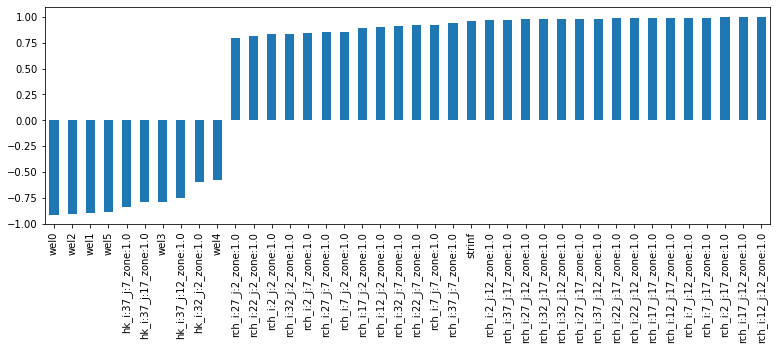

In [42]:
cpar = 'rch_i:12_j:12_zone:1.0'
R.df().loc[cpar][np.abs(R.df().loc[cpar])>.5].sort_values().plot(kind='bar', figsize=(13,4))

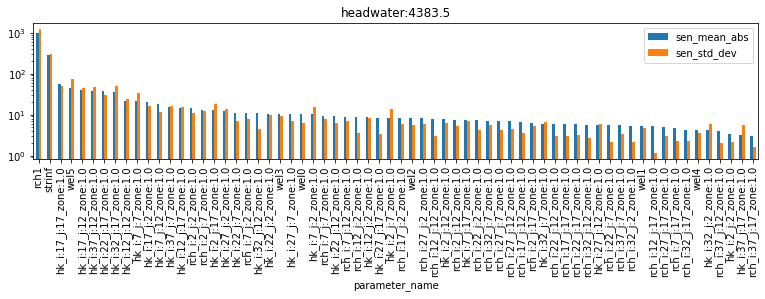

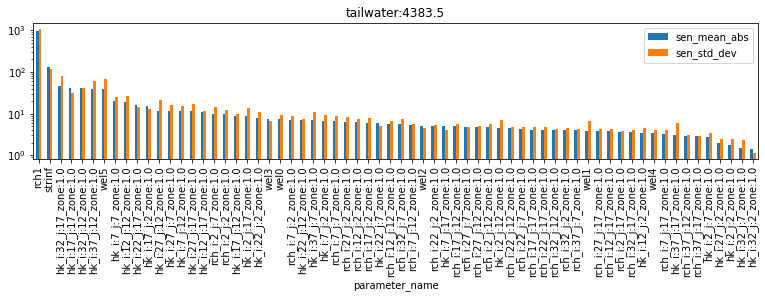

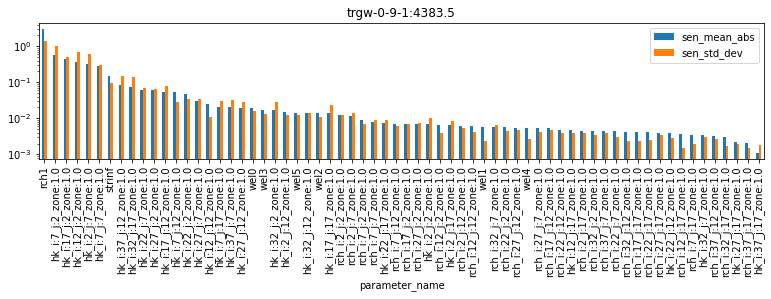

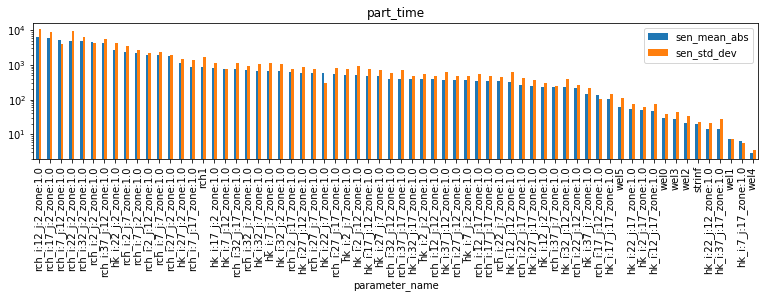

In [59]:
df_pred_sen = pd.read_csv(os.path.join(m_d,pst_name.replace(".pst",".mio")),skipinitialspace=True)

for forecast in pst.forecast_names:
    tmp_df = df_pred_sen.loc[df_pred_sen.observation_name==forecast].sort_values(by='sen_mean_abs', ascending=False)
    #tmp_df.plot(x='parameter_name',y='sen_mean_abs', kind='bar')
    tmp_df.plot(x="parameter_name",y=["sen_mean_abs","sen_std_dev"],kind="bar", figsize=(13,2.5))
    plt.title(forecast)
    plt.yscale('log');